# SPAM DETECTION OF YOU-TUBE COMMENTS USING RNN
### The necessary imports to perform preprocessing and 

In [265]:

import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt 
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences 

### Loading all Datasets

In [266]:

dfPsy = pd.read_csv(r"YouTube-Spam-Collection-v1/Youtube01-Psy.csv")
dfKatyPerry = pd.read_csv(r"YouTube-Spam-Collection-v1/Youtube02-KatyPerry.csv")
dfLMFAO = pd.read_csv(r"YouTube-Spam-Collection-v1/Youtube03-LMFAO.csv")
dfEminem = pd.read_csv(r"YouTube-Spam-Collection-v1/Youtube04-Eminem.csv")
dfShakira = pd.read_csv(r"YouTube-Spam-Collection-v1/Youtube05-Shakira.csv")

# Concatinating all the datasets to a single file.
df = pd.concat([dfPsy, dfKatyPerry, dfLMFAO, dfEminem, dfShakira])

### Initializing tokenizer and lemmatizer and writing a function for the preprocessing task

In [267]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def preprocess(col):
    '''
    Preprocessing includes: converting to lowercase, removing punctuation, tokenizing and lemmatizing
    input: text row of dataframe
    output: list with lemmatized words
    '''
    col = col.lower()
    col = [char for char in col if char not in punctuation]
    #rejoin the characters after removing punctuation
    col = ''.join(col)
    #tokenize and add pos tag so lemmatizer doesn't see all words as nouns
    col = nltk.pos_tag(w_tokenizer.tokenize(col))
    #lemmatize with WordNetLemmatizer
    return " ".join([lemmatizer.lemmatize(word, tag[0]) if tag[0] in ['a', 'r', 'n', 'v'] else word for word, tag in col])
#return [lemmatizer.lemmatize(word, tag[0].lower()) if tag[0].lower() in ['a', 'r', 'n', 'v'] else word for word, tag in col]

### Dropping the NA values

In [268]:
df["CONTENT"]=df["CONTENT"].dropna()

### Applying preprocessing to the Content column of the dataset.

In [269]:
df["CONTENT"]=df["CONTENT"].apply(preprocess)

### Performing the train-test split on the dataset (70/30 split)

In [270]:
X = df["CONTENT"]
Y = df["CLASS"]
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = .3,random_state = 42)

### Parameters for tokenizing the data and creating a word vocabulary.

In [272]:
max_len = 50  
trunc_type = "post"   
padding_type = "pre"   
oov_tok = "<OOV>"   
vocab_size = 500

### Creating an instance of the tokenizer with necessary parameters mentioned above and fit_on_texts updates the internal vocabulary dictionary based on the index of the words in the sentence.

In [273]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)  
tokenizer.fit_on_texts(X_train)

### Padding the tokenized training and testing set of the Content with the max-len which is passed as a parameter above.

In [274]:
training_sequences = tokenizer.texts_to_sequences(X_train)  
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(X_test)  
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,  
padding = padding_type, truncating = trunc_type)

### Checking the shape of both the training and testing tensor before model implementation.

In [275]:
print('Shape of training tensor: ', training_padded.shape)  
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1369, 50)
Shape of testing tensor:  (587, 50)


### Implementation of the RNN Model by assigning the embedding layer, RNN layers, Dropout Layer and the Dense Layer.

In [288]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(500,16,input_length=50),
    tf.keras.layers.SimpleRNN(20,return_sequences=True,activation = "relu"),
    tf.keras.layers.SimpleRNN(16,return_sequences=False,activation = "relu"),
    # tf.keras.layers.SimpleRNN(16,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 50, 16)            8000      
_________________________________________________________________
simple_rnn_68 (SimpleRNN)    (None, 50, 20)            740       
_________________________________________________________________
simple_rnn_69 (SimpleRNN)    (None, 16)                592       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 9,349
Trainable params: 9,349
Non-trainable params: 0
_________________________________________________________________


### Implementation of a Deep Vertical Neural Network.

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(1000,32,input_length=50),
#     tf.keras.layers.SimpleRNN(128,return_sequences=True),
#     tf.keras.layers.SimpleRNN(128,return_sequences=True),
#     tf.keras.layers.SimpleRNN(128,return_sequences=False),
#     # tf.keras.layers.SimpleRNN(16,return_sequences=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

### Fitting of the model and batching it and training the model for 20 epochs.

In [289]:
import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)
num_epochs = 20
history_rnn = model.fit(training_padded, Y_train, epochs=num_epochs, validation_data=(testing_padded, Y_test),batch_size = 32)

Epoch 1/20
43/43 [==============================] - 1s 27ms/step - loss: 0.6788 - accuracy: 0.6070 - val_loss: 0.6470 - val_accuracy: 0.6661
Epoch 2/20
43/43 [==============================] - 1s 16ms/step - loss: 0.5409 - accuracy: 0.7582 - val_loss: 0.4214 - val_accuracy: 0.8620
Epoch 3/20
43/43 [==============================] - 1s 16ms/step - loss: 0.3992 - accuracy: 0.8568 - val_loss: 0.4179 - val_accuracy: 0.8296
Epoch 4/20
43/43 [==============================] - 1s 19ms/step - loss: 0.3341 - accuracy: 0.8736 - val_loss: 0.2777 - val_accuracy: 0.8927
Epoch 5/20
43/43 [==============================] - 1s 17ms/step - loss: 0.2678 - accuracy: 0.9036 - val_loss: 0.2615 - val_accuracy: 0.8978
Epoch 6/20
43/43 [==============================] - 1s 20ms/step - loss: 0.2208 - accuracy: 0.9175 - val_loss: 0.2418 - val_accuracy: 0.8910
Epoch 7/20
43/43 [==============================] - 1s 26ms/step - loss: 0.1787 - accuracy: 0.9284 - val_loss: 0.2583 - val_accuracy: 0.8893
Epoch 8/20
43

### Plotting the Training accuracy vs Validation Accuracy and Training Loss vs Validation Loss.

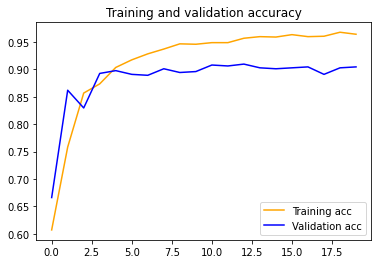

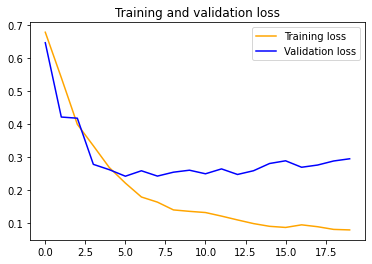

In [290]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history_rnn.history['accuracy']
val_acc = history_rnn.history['val_accuracy']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='Training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss, '-', color='orange', label='Training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Result

### We observe that the validation accuracy plateaus below the training accuracy around epoch 2.5. At the same time, the validation loss starts rising. This indicates overfitting again. The overall accuracy is quite high however. We also see several fluctuations in both the accuracy and the loss graph, this could have an effect of batching.

## References

### 1) https://www.tensorflow.org/guide/data
### 2) https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc
### 3) https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
### 4) https://keras.io/api/layers/recurrent_layers/simple_rnn/
### 5) https://stackoverflow.com/questions/43362986/numpy-frombuffer-attributeerror-str-object-has-no-attribute-buffer
### 6) https://www.gcptutorials.com/article/how-to-use-batch-method-in-tensorflow
### 7) https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do